<div style="
    background: linear-gradient(90deg,rgb(251, 255, 10), #ff758c, #ff4d6d);
    -webkit-background-clip: text;
    -webkit-text-fill-color: transparent;
    font-size: 20px;
    font-weight: bold;
    text-align: center;">
    ResNet Image Classification on Cipher Dataset
</div>



In [16]:
import os
import cv2
import numpy as np
import requests
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import UnidentifiedImageError
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Add, Activation, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.datasets import cifar10

In [17]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [35]:
def convolution_block(x, filters, s=2):
    f1, f2 = filters
    X_shortcut = x

    # First component of the main path
    x = Conv2D(f1, kernel_size=(3, 3), strides=(s, s), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    
    # Second component of the main path
    x = Conv2D(f2, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    
    # Shortcut path (match dimensions)
    X_shortcut = Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='same', activation='relu')(X_shortcut)
    X_shortcut = BatchNormalization()(X_shortcut)
    
    # Merge the paths
    x = Add()([x, X_shortcut])    
    x = Activation('relu')(x)
    return x


In [36]:
def identity_block(x, filters):
    f1, f2 = filters
    X_shortcut = x

    # First component of the main path
    x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    # Second component of the main path
    x = Conv2D(f2, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    # Add the shortcut connection to the main path
    x = Add()([x, X_shortcut])
    x = Activation('relu')(x)
    return x


$$\text{Actual model} $$

In [37]:
def ResNet(input_shape, num_classes):
    inputs = Input(input_shape) 
    
    # Stage-1 
    x = Conv2D(64, (5, 5), strides=(2, 2), name='conv1')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)
    
    # Stage-2
    x = convolution_block(x, filters=[64, 64], s=1)
    x = identity_block(x, filters=[64, 64])

    # Stage-3
    x = convolution_block(x, filters=[128, 128], s=2)
    x = identity_block(x, filters=[128, 128])
    
    # Stage-4
    x = convolution_block(x, filters=[256, 256], s=2)
    x = identity_block(x, filters=[256, 256]) 

    # Stage-5
    x = convolution_block(x, filters=[512, 512], s=2)
    x = identity_block(x, filters=[512, 512])
     
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model
     

In [38]:
model = ResNet(input_shape=(32, 32, 3), num_classes=10)

In [42]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 14, 14,    │      4,864 │ input_layer_10[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        256 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 6, 6, 64)  │          0 │ activation_9[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 6, 6, 64)  │     36,928 │ max_pooling2d_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 6, 64)  │        256 │ conv2d_26[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 6, 6, 64)  │     36,928 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 6, 6, 64)  │      4,160 │ max_pooling2d_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 6, 64)  │        256 │ conv2d_27[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 6, 64)  │        256 │ conv2d_28[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 6, 6, 64)  │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 6, 6, 64)  │          0 │ add_5[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 6, 6, 64)  │     36,928 │ activation_10[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 6, 64)  │        256 │ conv2d_29[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 6, 6, 64)  │     36,928 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 6, 64)  │        256 │ conv2d_30[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 6, 6, 64)  │          0 │ batch_normalizat… │
│                     │                   │            │ activation_10[0]… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 33,568,096 (128.05 MB)

 Trainable params: 11,186,122 (42.67 MB)

 Non-trainable params: 9,728 (38.00 KB)

 Optimizer params: 22,372,246 (85.34 MB)

In [40]:
model.compile(
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    optimizer='adam',
)

In [44]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 166s 106ms/step - accuracy: 0.5302 - loss: 1.3587 - val_accuracy: 0.4032 - val_loss: 1.7342
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 165s 105ms/step - accuracy: 0.6104 - loss: 1.1348 - val_accuracy: 0.4088 - val_loss: 2.4245
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 167s 107ms/step - accuracy: 0.6273 - loss: 1.1051 - val_accuracy: 0.5560 - val_loss: 1.4768
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 167s 107ms/step - accuracy: 0.6805 - loss: 0.9308 - val_accuracy: 0.5964 - val_loss: 1.2744
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 166s 106ms/step - accuracy: 0.7160 - loss: 0.8288 - val_accuracy: 0.6869 - val_loss: 0.9271
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 166s 106ms/step - accuracy: 0.7297 - loss: 0.7871 - val_accuracy: 0.6869 - val_loss: 52.4650
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 166s 106ms/step - accuracy: 0.7694 - loss: 0.6682 - val_accuracy: 0.6944 - val_loss: 7.4682
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 167s 107ms/step - a

In [56]:
def preedict_image(url):
    try:
        response = requests.get(url, stream=True)
        if response.status_code == 200 and 'image' in response.headers['Content-Type']:
            with open("download_image.jpg", "wb") as f:
                f.write(response.content)
        else:
            print("Invalid image URL or content type.")
            return


        img = load_img("download_image.jpg", target_size=(32, 32))
        plt.imshow(img)
        plt.axis('off')
        plt.show()


        img = img_to_array(img)
        img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)


        y_pred = model.predict(img)
        predictions = decode_predictions(y_pred, top=5)[0]


        for _, label, prob in predictions:
            print(f"{label}: {prob:.2f}")

    except UnidentifiedImageError:
        print("Failed to identify the image. Please check the URL.")

    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if os.path.exists("download_image.jpg"):
            os.remove("download_image.jpg")


In [69]:
from tensorflow.keras.utils import plot_model
plot_model(
    model,
    show_layer_names=True,
)

You must install pydot (`pip install pydot`) for `plot_model` to work.


<Axes: >

<Figure size 2000x3000 with 0 Axes>

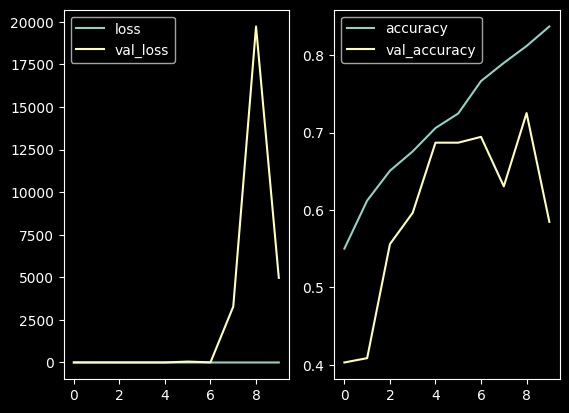

In [78]:
import pandas as pd
hist_df = pd.DataFrame(history.history) 

plt.figure(figsize=(20, 30))
fig, axes = plt.subplots(1,2)
hist_df.plot(y=['loss', 'val_loss'], ax= axes[0])
hist_df.plot(y=['accuracy', 'val_accuracy'], ax = axes[1])